## 导入包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from rich.progress import Progress
# 设定随机种子
np.random.seed(42)

## 定义类和函数，用于生成协方差矩阵、实施各种截断方法

In [2]:
class SigmaGenerator:
    """
    生成 Model 1 的协方差矩阵
    """

    def __init__(self, p):
        # 必须保证 p 为偶数，否则无法生成 Model 1 的协方差矩阵
        assert p % 2 == 0, "p must be even"
        self.p = int(p / 2)

    def A_1_sigma(self):
        """
        生成 A1
        """
        # 初始化 A1
        matrix = np.zeros((self.p, self.p))
        # 生成 A1 中的第 i 行 第 j 列的值
        for i in range(self.p):
            for j in range(self.p):
                matrix[i][j] = max(0, 1 - abs(i - j) / 10)
        return matrix

    def A_2_sigma(self):
        """
        生成 A2
        """
        # 初始化 A2，对角线元素均为 4，其他元素均为 0
        matrix = 4 * np.eye(self.p)
        return matrix

    def gen_sigma(self):
        """
        生成 Model 1 的协方差矩阵
        """
        # 用 A1 和 A2 两个 bolck 组成 sigma
        matrix = np.block(
            [
                [self.A_1_sigma(), np.zeros((self.p, self.p))],
                [np.zeros((self.p, self.p)), self.A_2_sigma()],
            ]
        )
        return matrix


class Thresholding:
    def __init__(self, vectors, labels=None):
        self.vectors = vectors
        self.labels = labels
        self.n = vectors.shape[0]
        self.p = vectors.shape[1]

    def cal_cov(self, vectors=None):
        """
        计算协方差矩阵

        Args:
            vectors: 多个向量

        Returns:
            cov: 协方差矩阵
        """
        # 如果没有传入 vectors，则使用 self.vectors
        if vectors is None:
            vectors = self.vectors
        # 如果传入 vectors，则使用传入的 vectors
        cov = np.cov(vectors, rowvar=False)
        return cov

    def cal_risk(
        self, cov_1: np.ndarray, cov_2: np.ndarray, norm_type: str = "operator"
    ):
        """
        计算两个协方差矩阵之差的 norm

        Args:
            cov_1: 协方差矩阵 1
            cov_2: 协方差矩阵 2
            norm_type: norm 的类型，可选 'Operator norm', 'Matrix l1 norm' or 'Frobenius norm'

        Returns:
            risk: 两个协方差矩阵之差的 norm
        """
        # 断言 cov_1 和 cov_2 的形状相同
        assert cov_1.shape == cov_2.shape, "cov_1 and cov_2 must have the same shape"
        diff = cov_1 - cov_2
        if norm_type == "Operator norm":
            risk = np.linalg.norm(diff, ord=2)
        elif norm_type == "Matrix l1 norm":
            risk = np.linalg.norm(diff, ord=1)
        elif norm_type == "Frobenius norm":
            risk = np.linalg.norm(diff, ord="fro")
        else:
            raise ValueError(
                "norm_type must be 'Operator norm', 'Matrix l1 norm' or 'Frobenius norm'"
            )
        return risk

    def thresholding(self, cov: np.ndarray, threshold: np.ndarray):
        """
        对协方差矩阵进行 thresholding

        Args:
            cov: 协方差矩阵
            threshold: 截断标准矩阵

        Returns:
            cov: 截断后的协方差矩阵
        """
        # 断言 cov 和 threshold 的形状相同
        assert (
            cov.shape == threshold.shape
        ), "cov and threshold must have the same shape"
        # copy() 是为了防止修改原矩阵
        cov = cov.copy()
        # 对协方差矩阵进行 thresholding
        # 将绝对值小于 threshold 的元素置为 0
        cov[np.abs(cov) < threshold] = 0
        return cov

    def cal_theta_hat(self):
        """
        计算 theta_hat

        Returns:
            theta_hat: theta_hat
        """
        # 计算 sigma_hat
        sigma_hat = self.cal_cov()
        # 计算 theta_hat
        theta_hat = np.zeros((self.p, self.p))
        for i in range(self.p):
            x_i_bar = np.mean(self.vectors[:, i])
            for j in range(self.p):
                x_j_bar = np.mean(self.vectors[:, j])
                for k in range(self.n):
                    theta_hat[i][j] += (
                        (self.vectors[k][i] - x_i_bar) * (self.vectors[k][j] - x_j_bar)
                        - sigma_hat[i][j]
                    ) ** 2
        theta_hat /= self.n
        return theta_hat

    def get_best_threshold_using_cv(
        self,
        method: str = "universal",
        norm_type: str = "operator",
        N: int = 10,
        split_method: str = "KFold",
    ):
        """
        使用交叉验证对样本进行 thresholding，选取最优的截断标准矩阵 threshold

        Args:
            method: thresholding 的方法，可选 universal, adaptive, adaptive2
            norm_type: norm 的类型，可选 operator, l1, frobenius
            N: 交叉验证的折数
            split_method: 交叉验证的方法，可选 KFold, StratifiedKFold

        Returns:
            threshold: 最优的截断标准矩阵

        """
        # 计算样本协方差矩阵中的最大元素值
        max_cov = np.max(np.abs(self.cal_cov()))
        # 构造 delta 的候选集，最小为0， 最大为原协方差矩阵中的最大值，共 5 个候选值
        delta_candidates = np.linspace(0, max_cov, 5)
        if method == "Universal":
            # 构造 threshold 的候选集，它是一个 1 维数组，每个元素代表一个 threshold
            threshold_candidates = delta_candidates * np.sqrt(np.log(self.p) / self.n)
            # 将 threshold_candidates 转换为列表，列表中的元素为 self.p * self.p 的矩阵，矩阵中的元素均为 threshold
            threshold_candidates = [
                np.full((self.p, self.p), threshold)
                for threshold in threshold_candidates
            ]
        elif method == "Adaptive":
            # 计算 theta_hat
            theta_hat = self.cal_theta_hat()
            # 构造 threshold 的候选集
            threshold_candidates = [
                delta * np.sqrt(theta_hat * np.log(self.p) / self.n)
                for delta in delta_candidates
            ]
        elif method == "Adaptive2":
            # 计算 theta_hat
            theta_hat = self.cal_theta_hat()
            # 使用 delta = 2
            return 2 * np.sqrt(theta_hat * np.log(self.p) / self.n)
        else:
            raise ValueError("method must be Universal, Adaptive or Adaptive2")
        # 构造交叉验证划分样本的实例
        if split_method == "KFold":
            spliter = KFold(n_splits=N, shuffle=True, random_state=42)
        elif split_method == "StratifiedKFold":
            spliter = StratifiedKFold(n_splits=N, shuffle=True, random_state=42)
        else:
            raise ValueError("split_method must be KFold or StratifiedKFold")
        # 构造 risks 列表，用于存储每次交叉验证的 risk
        risks = []
        # 构造交叉验证的分割索引
        if split_method == "KFold":
            split_index = spliter.split(self.vectors)
        elif split_method == "StratifiedKFold":
            split_index = spliter.split(self.vectors, self.labels)
        else:
            raise ValueError("split_method must be KFold or StratifiedKFold")
        # 遍历 threshold_candidates 中的每个 threshold
        for threshold in threshold_candidates:
            risk = 0
            for n_1_index, n_2_index in split_index:
                # 计算训练集和测试集的协方差矩阵
                cov_n_1 = self.cal_cov(self.vectors[n_1_index])
                cov_n_2 = self.cal_cov(self.vectors[n_2_index])
                # 将 cov_n_1 进行 thresholding
                cov_n_1 = self.thresholding(cov_n_1, threshold)
                # 计算训练集和测试集的 risk
                risk += self.cal_risk(cov_n_1, cov_n_2, norm_type)
                # 将 risk 的均值添加到 risks 中
            risks.append(risk / N)
        # 选取 risks 中的最小 risk 对应的 threshold
        threshold = threshold_candidates[np.argmin(risks)]
        return threshold

# Table 1

## 构造数据框，存储结果

In [3]:
# 构造双重索引
idx = pd.MultiIndex.from_product(
    [
        ["Operator norm", "Matrix l1 norm", "Frobenius norm"],
        [30, 100, 200],
    ],
    names=["norm_type", "p"],
)
# 定义列名
col_names = ["Universal", "Adaptive", "Adaptive2"]
# 创建空的 DataFrame
table_1 = pd.DataFrame(columns=col_names, index=idx)

## 计算各维度、各截断方法、各参数下的 risk 均值和标准误

## 复现 Table 1

In [4]:
# 重复 100 次，计算 risk
def replication(progress, task, mu, cov, method, norm_type):
    # 定义 risks 列表，用于存储 risk
    risk_list = []
    # 重复 100 次，计算 risk 的均值和标准差
    for _ in range(100):
        # 生成 100 个 p 元正态分布的随机向量
        vectors = np.random.multivariate_normal(mu, cov, 100)
        # 定义 Thresholding 实例
        thresholding = Thresholding(vectors)
        # 计算样本协方差矩阵
        cov_hat = thresholding.cal_cov()
        # 进行 10 次交叉验证，取最优截断标准矩阵
        best_threshold = thresholding.get_best_threshold_using_cv(method, norm_type, N=10)
        # 对样本协方差矩阵进行 thresholding
        cov_hat_after_thresholding = thresholding.thresholding(cov_hat, best_threshold)
        # 计算 risk
        risk = thresholding.cal_risk(cov_hat_after_thresholding, cov, norm_type)
        # 将 risk 加入 risk_list
        risk_list.append(risk)
        # 更新进度条
        progress.update(task, advance=1)
    return risk_list

In [5]:
with Progress() as progress:
    task = progress.add_task("[green]正在计算...", total=3 * 3 * 3 * 100)
    for p in [30, 100, 200]:
        # 生成真实的 p 元正态分布的均值向量和协方差矩阵
        mu = np.zeros(p)
        cov = SigmaGenerator(p).gen_sigma()
        # 遍历三种截断方法
        for method in ["Universal", "Adaptive", "Adaptive2"]:
            # 遍历三种计算 risk 的方法
            for norm_type in ["Operator norm", "Matrix l1 norm", "Frobenius norm"]:
                # 重复 100 次，计算 risk
                risk_list = replication(
                    progress, task, mu, cov, method, norm_type
                )
                # 计算 risk 的均值和标准差
                risk_mean = np.mean(risk_list)
                risk_std_error = np.std(risk_list) / np.sqrt(100)
                table_1.loc[
                    (norm_type, p), method
                ] = f"{risk_mean:.2f} ({risk_std_error:.2f})"

Output()

In [6]:
table_1

Universal      Adaptive     Adaptive2
norm_type      p                                            
Operator norm  30    3.49 (0.05)   2.03 (0.05)   1.83 (0.05)
               100   7.34 (0.05)   2.64 (0.05)   2.97 (0.05)
               200  11.18 (0.06)   3.00 (0.04)   3.75 (0.05)
Matrix l1 norm 30    8.88 (0.15)   3.07 (0.10)   2.63 (0.06)
               100  25.22 (0.27)   4.68 (0.10)   4.77 (0.06)
               200  44.74 (0.37)   5.28 (0.12)   5.85 (0.10)
Frobenius norm 30    7.31 (0.05)   4.01 (0.06)   3.25 (0.05)
               100  22.50 (0.07)   7.91 (0.09)   7.52 (0.05)
               200  43.48 (0.11)  11.11 (0.10)  11.72 (0.06)

## 将结果导出到本地表格

In [7]:
table_1.to_csv('./Table 1.csv')

# Table 2

## 定义计算 F 统计量的函数

In [8]:
def cal_F_statistics(df: pd.DataFrame, gene: str) -> float:
    """
    计算 F 统计量

    Args:
        df: DataFrame, 数据集
        gene: str, 基因名

    Returns:
        F: float, F 统计量
    """
    # n 是样本数
    n = len(df)
    # k 是类别数
    k = len(df["class"].unique())
    # x_bar 是总体均值
    x_bar = df[gene].mean()
    # 计算 F 统计量的分子
    numerator = 0
    for m in df["class"].unique():
        df_m = df[df["class"] == m]
        # x_bar_m 是第 m 类的均值
        x_bar_m = df_m[gene].mean()
        # n_m 是第 m 类的样本数
        n_m = len(df_m)
        numerator += n_m * (x_bar_m - x_bar) ** 2
    numerator /= k - 1
    # 计算 F 统计量的分母
    denominator = 0
    for m in df["class"].unique():
        df_m = df[df["class"] == m]
        # sigma_m_square 是第 m 类的样本方差
        sigma_m_square = df_m[gene].var()
        # n_m 是第 m 类的样本数
        n_m = len(df_m)
        denominator += (n_m - 1) * sigma_m_square
    denominator /= n - k
    # 计算 F 统计量
    F = numerator / denominator
    return F


## 读取数据

In [9]:
df = pd.read_csv('./SRBCT$X+class.csv', index_col=0).iloc[:63]

## 筛选出 F 统计量最大的 40 个基因和最小的 160 个基因

In [10]:
# 计算每个基因的 F 统计量
F_statistics = {}
for gene in df.columns[:-1]:
    F_statistics[gene] = cal_F_statistics(df, gene)
# 筛选出 F 统计量最大的 40 个基因和最小的 160 个基因
top_40_genes = sorted(
    F_statistics,
    key=F_statistics.get,
    reverse=True,
)[:40]
bottom_160_genes = sorted(
    F_statistics,
    key=F_statistics.get,
    reverse=True,
)[-160:]
# 提取 top_40_genes 和 bottom_160_genes 中的基因
df = df[top_40_genes + bottom_160_genes + ["class"]]

In [11]:
df

,V123,V1389,V742,V846,V1158,V1606,V1955,V335,V758,V545,...,V1278,V1653,V1982,V813,V1830,V1681,V524,V303,V305,class
1,0.1844,4.0134,0.1831,0.3863,0.6295,0.2537,0.4964,0.2869,0.8240,3.9433,...,0.1138,3.2109,0.2940,0.4900,0.1197,0.4171,0.2586,0.0749,0.4050,1
2,0.2833,2.3451,0.9324,0.6338,0.5987,1.0198,0.4959,0.4643,0.9112,4.4723,...,0.2039,0.5356,0.3585,0.5916,0.0933,0.7674,0.1433,0.0874,0.3516,1
3,0.2713,4.1262,0.2683,0.3197,0.6311,1.0740,0.6070,0.3192,0.3791,2.0101,...,0.1744,0.5314,0.8738,0.4830,0.1690,0.6715,0.3611,0.1722,0.2223,1
4,0.3253,5.1079,0.6081,0.1897,0.1804,0.7540,0.2547,0.7217,0.1961,4.3301,...,0.1924,2.1751,1.0699,0.1945,0.3227,0.2794,0.2178,2.1712,0.4948,1
5,0.2585,3.9941,0.2854,0.2734,0.9005,0.7351,0.9249,0.5506,0.7654,3.3461,...,0.1453,2.8353,0.5070,0.7004,0.1255,0.2004,1.7506,0.1756,1.0945,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.2031,0.5444,0.2994,0.6824,0.7162,0.1605,2.0514,0.2170,1.2261,1.7112,...,0.1296,3.1233,0.6193,0.3301,0.6592,0.5075,2.0596,0.2604,0.6594,4
60,0.3699,0.6624,0.6356,0.4988,1.1358,0.3754,7.9145,0.3138,0.8234,1.5225,...,0.3209,6.5490,0.9351,0.4001,0.4064,0.4449,1.1318,0.5902,0.7324,4
61,0.2915,0.6417,1.0611,0.1560,0.6460,0.6097,2.7369,0.5889,0.2499,0.8159,...,0.2182,1.6202,0.4261,0.4854,0.2125,0.8829,0.1557,0.1707,0.3710,4
62,0.1499,0.8647,0.7529,0.5509,0.7270,0.1506,2.9856,0.1554,0.4747,2.8437,...,0.0657,4.5241,0.5766,0.5480,0.0855,0.5424,0.3873,0.2613,0.3401,4


In [12]:
# 创建 Thresholding 实例
thresholding = Thresholding(vectors=df.iloc[:, :-1].values, labels=df["class"].values)
# 计算样本协方差矩阵
cov_hat = thresholding.cal_cov()

## 绘制不同截断方法下的热力图

In [13]:
def plot_heat_map(method):
    # 进行 5 次交叉验证，取最优截断标准矩阵。使用 StratifiedKFold 进行交叉验证，尽量使四种类别的样本在每折中的比例相同
    best_threshold = thresholding.get_best_threshold_using_cv(
        method, "Frobenius norm", N=5, split_method="StratifiedKFold"
    )
    # 对样本协方差矩阵进行 thresholding
    cov_hat_after_thresholding = thresholding.thresholding(cov_hat, best_threshold)
    # 绘制黑白图片
    plt.imshow(cov_hat_after_thresholding > 0, cmap="gray_r")
    zeros_proportion = 1 - np.count_nonzero(cov_hat_after_thresholding) / np.size(
        cov_hat_after_thresholding
    )
    # 将 zeros_proportion 作为图片的标题
    plt.title("{}: {:.2%} zeros".format(method, zeros_proportion))
    # 导出到本地 png 格式的图片
    plt.savefig(
    "./{}.png".format(method),
    format="png",
    facecolor="white",
    bbox_inches="tight",
)


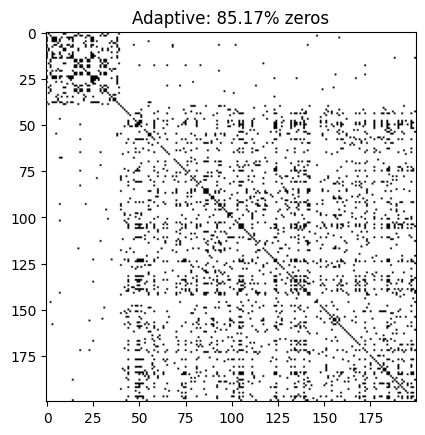

In [14]:
plot_heat_map('Adaptive')

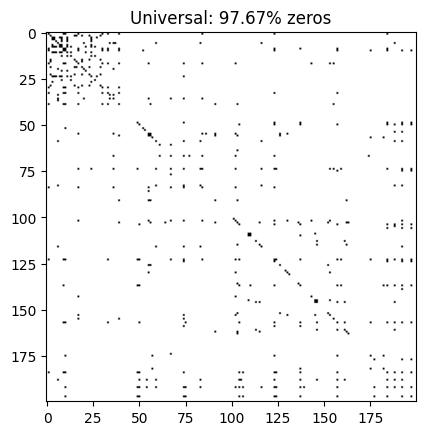

In [15]:
plot_heat_map('Universal')